In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support
#import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_recall_curve
from tabulate import tabulate # pretty print tables
import tensorflow.keras.datasets.mnist as mnist
import tensorflow.keras.datasets.fashion_mnist as fashion_mnist
from sklearn.linear_model import SGDClassifier

# Logistic Regression on the Fashion MNIST Dataset

As a precursor to neural networks, we will attempt to apply the methods we have learnt to datasets which are considered foundational for neural networks. We will focus on the Fashion MNIST dataset of clothing items. These images are grayscale with pixel intensity between 0 to 255. We normalize this out by dividing by 255 so the data are scaled between 0 and 1.

We will find that Logistic Regression reaches a test accuracy of 81\% approx. A baseline computation using neural networks will turn out to give us around 89 \% accuracy, for comparison.

In [2]:
data = fashion_mnist

(x_train,y_train),(x_test,y_test)= data.load_data()

x_train, x_test = x_train/255. , x_test/255.

print('number of elements in train: {} and test: {}'.format(len(x_train),len(x_test)))

print('discard all by 1% of the data')

retain_size = 0.1

x_train, _, y_train, _ = train_test_split(x_train,y_train,train_size=retain_size,stratify=y_train)
_, x_test, _, y_test = train_test_split(x_test,y_test,test_size=retain_size,stratify=y_test)

print('number of elements in train: {} and test: {}'.format(len(x_train),len(x_test)))

print('shape of input vectors:', x_train[0].shape)

number of elements in train: 60000 and test: 10000
discard all by 1% of the data
number of elements in train: 6000 and test: 1000
shape of input vectors: (28, 28)


In [30]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

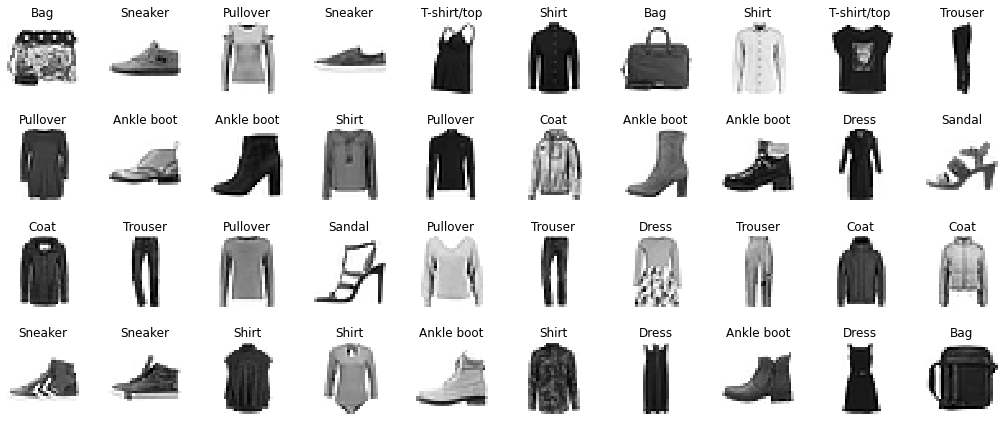

In [33]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.8, n_rows * 1.8))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [6]:
x_train = x_train.reshape(*x_train.shape[:1],-1)
x_test = x_test.reshape(*x_test.shape[:1],-1)

In [7]:
x_train.shape

(6000, 784)

# Visualizing the Dataset as a Point Cluster

In [8]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(x_train)
X_2d.shape, np.cumsum(pca.explained_variance_)

((6000, 2), array([19.34025143, 31.3548235 ]))

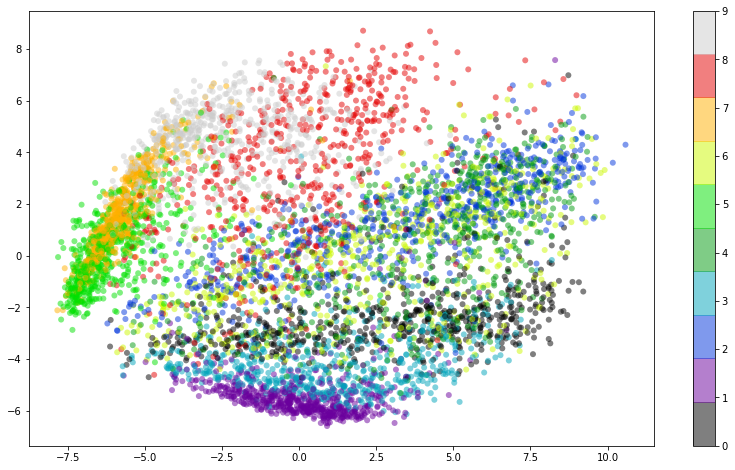

In [34]:
plt.figure(figsize=(14,8))
plt.scatter(X_2d[:,0],X_2d[:,1],c=y_train,edgecolor='none',alpha=0.5,cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

# The Logistic Regression Model

As mentioned before, we will use multinary Logistic Regression to classify this dataset. This time we will scan across possibilities of regularization (L1 or ElasticNet) as well as candidate values for the regularization coefficients.

## Choosing Features

Our features will be the individual pixel values themselves. In particular, suppose an image $\mathcal{I}$ consists of pixels $p_{ij}$ located at position $ij$ on the image grid. Then our feature vector $\phi\left(\mathcal{I}\right)$ will be
\begin{equation}
\phi\left(\mathcal{I}\right)_k = p_{ij}, \qquad k \equiv \left(i,j\right)\,.
\end{equation}
Operationally, this means we can unroll the $2d$ images in <tt>x_train</tt> and <tt>x_test</tt> into $1d$ dimensional vectors which are then input into the Logistic Regression classifier.

In [15]:
softmax_reg = SGDClassifier(loss='log_loss',penalty='l1',alpha=1e-3,verbose=0)
softmax_reg.fit(x_train,y_train)

SGDClassifier(alpha=0.001, loss='log_loss', penalty='l1')

In [21]:
softmax_reg = SGDClassifier(loss='log_loss',penalty='l1',alpha=1e-3,verbose=0)

param_grid = [{'penalty':['l1','elasticnet'],'alpha':[1e-2,1e-3,1e-4,1e-5],'l1_ratio':[0.5,1e-1,1e-2]}]

gridsearch = GridSearchCV(softmax_reg,param_grid,cv=5)

gridsearch.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=SGDClassifier(alpha=0.001, loss='log_loss',
                                     penalty='l1'),
             param_grid=[{'alpha': [0.01, 0.001, 0.0001, 1e-05],
                          'l1_ratio': [0.5, 0.1, 0.01],
                          'penalty': ['l1', 'elasticnet']}])

In [100]:
final_model = gridsearch.best_estimator_
gridsearch.best_estimator_

SGDClassifier(alpha=0.001, l1_ratio=0.1, loss='log_loss', penalty='elasticnet')

In [22]:
y_tr_pred = gridsearch.predict(x_train)
print('accuracy reached on train set: ',accuracy_score(y_train,y_tr_pred))

accuracy reached on train set:  0.8665


In [62]:
y_pred = gridsearch.predict(x_test)
print('accuracy reached on test set: ',accuracy_score(y_test,y_pred))
print('matthews correlation coefficient on the test set: {:.3f}'.format(matthews_corrcoef(y_test,y_pred)))

accuracy reached on test set:  0.804
matthews correlation coefficient on the test set: 0.783


## Enumerating Misclassifications

We enumerate misclassifications by computing the _confusion matrix_. 

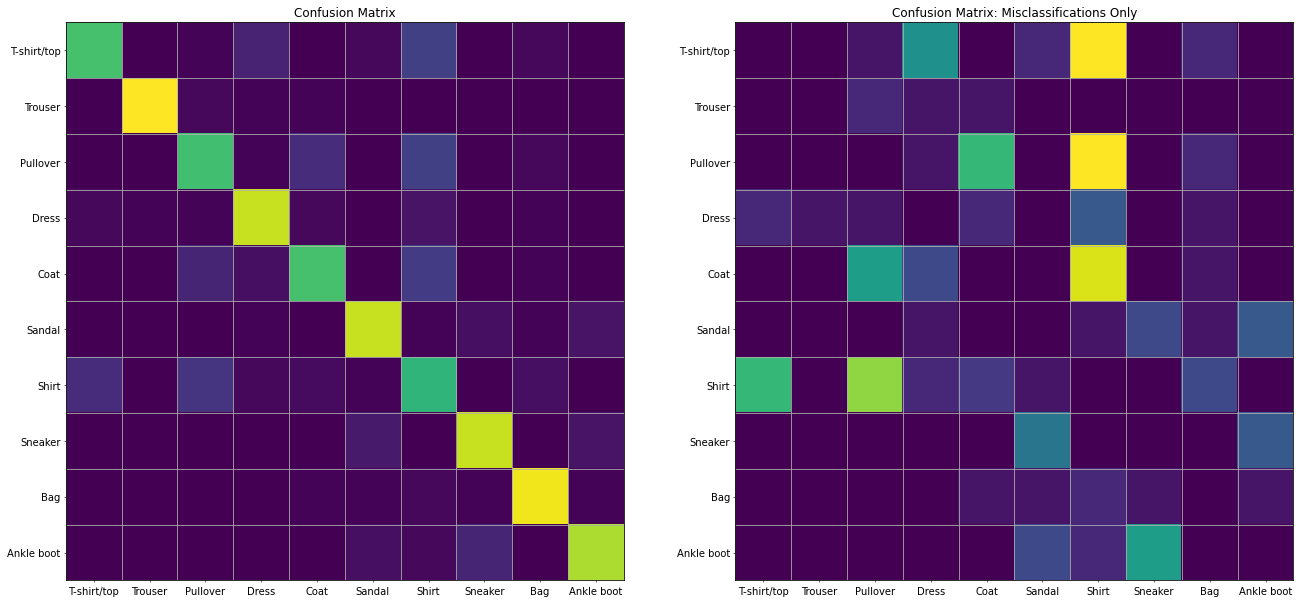

In [197]:
confusionmatrix = confusion_matrix(y_test,y_pred)
fig, axes = plt.subplots(frameon=False,nrows=1,ncols=2,figsize = (22,22))
axes[0].imshow(confusionmatrix)
axes[0].set_title('Confusion Matrix')
np.fill_diagonal(confusionmatrix,0)
axes[1].imshow(confusionmatrix)
axes[1].set_title('Confusion Matrix: Misclassifications Only')
for ax in axes:
    ax.grid('both')
    ax.set_xticks(np.arange(-0.5, 10, 1))
    ax.set_yticks(np.arange(-0.5, 10, 1))
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
    ax.set_xticks(np.arange(0,10,1),minor=True) # plot labels between ticks
    ax.set_xticklabels(class_names,minor=True)
    ax.set_yticks(np.arange(0,10,1),minor=True)
    ax.set_yticklabels(class_names,minor=True)
plt.show()

Brighter Colors denote larger values.

The bulk of the confusions appear to be between a shirt and a T-shirt, Pullover or Coat, which are plausible mistakes to make.

In [37]:
print('confusion matrix after removing diagonal elements:')
print(confusionmatrix)

confusion matrix after removing diagonal elements:
[[ 0  1  3  9  0  2 12  0  0  0]
 [ 2  0  0  2  0  0  0  0  0  0]
 [ 4  0  0  2 17  0 20  0  1  0]
 [ 4  4  1  0  1  1  3  0  1  0]
 [ 1  2  7  5  0  0 13  0  0  0]
 [ 0  0  0  0  0  0  2  7  1  4]
 [14  1 12  5  7  1  0  0  4  0]
 [ 0  0  0  0  0  9  0  0  0  5]
 [ 0  1  0  0  0  3  3  2  0  0]
 [ 0  0  0  3  0  3  0  9  0  0]]


# Precision, Recall, Fscore

We have already defined precision, recall and the F1 score for binary classification. These metrics can be arrived at from enumerating true positives <b>(TP)</b>, true negatives <b>(TN)</b>, false positives <b>(FP)</b>, false negatives <b>(FN)</b>. 

They are also extendible to multinary classification. Suppose for the class $c_i$ our classifier outputs $TP_i$ true positives, $TN_i$ true negatives, $FP_i$ false positives and $FN_i$ false negatives. A perfectly functioning classifier will have only true positives and true negatives, there will be no false positives or negatives. This is also when the accuracy will be 100\%.
1. _precision :_ For the i-th class 
\begin{equation} p_i = \frac{TP_i}{TP_i+FP_i} \end{equation}
i.e. the number of true positives in all detected positive.
2. _recall :_ For the i-th class
\begin{equation} r_i = \frac{TP_i}{TP_i+FN_i} \end{equation}
i.e. encodes the number of positives missed by the classifier.

We can also organize precision and recall into a single number, the F1 score.
\begin{equation} f_{1;i} = 2\frac{p_i*r_i}{p_i+r_i} \end{equation}
We now compute the precision, recall and f1 scores of the SGDClassifier trained on the Fashion MNIST data.

In [199]:
precision, recall, f1score, _ = precision_recall_fscore_support(y_train, y_tr_pred, average=None)

scores = pd.DataFrame()
scores['class'] = class_names
scores['precision'] = precision
scores['recall'] = recall
scores['f1score'] = f1score
scores.index += 1

print('Class scores on Train Set ordered by decreasing F1')
print(tabulate(scores.round(3).sort_values(by='f1score',ascending=False)
               , headers = 'keys', tablefmt = 'pretty'))

Class scores on Train Set ordered by decreasing F1
+----+-------------+-----------+--------+---------+
|    |    class    | precision | recall | f1score |
+----+-------------+-----------+--------+---------+
| 2  |   Trouser   |   0.991   |  0.96  |  0.975  |
| 9  |     Bag     |   0.937   | 0.947  |  0.942  |
| 6  |   Sandal    |   0.89    |  0.94  |  0.914  |
| 10 | Ankle boot  |   0.932   | 0.895  |  0.913  |
| 8  |   Sneaker   |   0.902   | 0.903  |  0.903  |
| 4  |    Dress    |   0.884   | 0.888  |  0.886  |
| 1  | T-shirt/top |   0.906   | 0.785  |  0.841  |
| 3  |  Pullover   |   0.808   | 0.822  |  0.815  |
| 5  |    Coat     |   0.839   |  0.73  |  0.781  |
| 7  |    Shirt    |   0.639   | 0.795  |  0.708  |
+----+-------------+-----------+--------+---------+


In [97]:
precision, recall, f1score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

scores = pd.DataFrame()
scores['class'] = class_names
scores['precision'] = precision
scores['recall'] = recall
scores['f1score'] = f1score
scores.index += 1

print('Class scores on Test Set ordered by decreasing F1')
print(tabulate(scores.round(3).sort_values(by='f1score',ascending=False)
               , headers = 'keys', tablefmt = 'pretty'))

Class scores ordered by decreasing F1
+----+-------------+-----------+--------+---------+
|    |    class    | precision | recall | f1score |
+----+-------------+-----------+--------+---------+
| 2  |   Trouser   |   0.99    |  0.96  |  0.975  |
| 9  |     Bag     |   0.895   |  0.94  |  0.917  |
| 6  |   Sandal    |   0.854   |  0.88  |  0.867  |
| 8  |   Sneaker   |   0.854   |  0.88  |  0.867  |
| 10 | Ankle boot  |   0.884   |  0.84  |  0.862  |
| 4  |    Dress    |   0.83    |  0.88  |  0.854  |
| 1  | T-shirt/top |   0.829   |  0.68  |  0.747  |
| 5  |    Coat     |   0.782   |  0.68  |  0.727  |
| 3  |  Pullover   |   0.698   |  0.67  |  0.684  |
| 7  |    Shirt    |    0.5    |  0.63  |  0.558  |
+----+-------------+-----------+--------+---------+


From these numbers we see that the classifier works very well on some classes ('Trouser', 'Bag'), acceptably on some others while the performance on some classes such as 'Pullover' and 'Shirt' can be improved.